In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#RMSLE
import timeit
import math
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [6]:
# Make predictions fit for Kaggle
# No negatives
def fit_for_kaggle(y):
    for i in range(len(y)):
        y[i] = max(0,y[i])
# Only int
    y = y.astype(int)
    return y

In [7]:
# Exports in Kaggle format
def Export_for_Kaggle(y_pred, path):
# path is the name of the file "x.csv"
    data_out = pd.DataFrame(y_pred, columns = ['Prediction'])
    data_out.index.name = 'Id'
    data_out.to_csv(path, sep = ",")
    
    return

In [8]:
#import all data
feature_data = pd.read_csv('kaggle_data/features.txt', header=None, sep="  ", names=['feature_names', 'feature_description'], engine='python')
list_feature_names = list(feature_data['feature_names'])
train_data = pd.read_csv('kaggle_data/train.csv', header=None, sep=" ", names=list_feature_names)
test_data=pd.read_csv('kaggle_data/test-val.csv',header=None,sep=" ",names=list_feature_names)
target_data = pd.read_csv('kaggle_data/train-targets.csv', sep=",")

In [9]:
#Data engineering 

# 'weekday' encoding
weekday_data = pd.get_dummies(train_data['weekday'],prefix='weekday',drop_first=True)

# 'category' encoding
category_data = pd.get_dummies(train_data['category'],prefix='category',drop_first=True)

#fusion that shit
other_data = train_data.drop(['weekday','category'],axis=1)
training_data = pd.concat([category_data,weekday_data,other_data],axis=1)

In [10]:
#lets do the same with the test data
weekday_data_test=pd.get_dummies(test_data['weekday'],prefix='weekday',drop_first=True)
category_data_test=pd.get_dummies(test_data['category'],prefix='category',drop_first=True)
other_data_test=test_data.drop(['weekday','category'],axis=1)
testing_data=pd.concat([category_data_test,weekday_data_test,other_data_test],axis=1)

#see it
#testing_data.head(5)


In [11]:
#Data standardization
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(training_data)
X_reg = scaler.transform(training_data)
y_reg = target_data['Prediction'].values

#scale that test data
X_test = scaler.transform(testing_data)

#visualize X_reg
#print X_reg

In [12]:
# Making the kfold
from sklearn import model_selection
kf = model_selection.KFold(n_splits = 10)
k_folds = kf.split(X_reg, y_reg)

In [13]:
# Setting up the Linear regression
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

In [14]:
# Predictions by Cross validation
y_pred = model_selection.cross_val_predict(lin_reg, X_reg, y_reg, cv=k_folds)
# num shares can't be negative, so 0 instead
fit_for_kaggle(y_pred)

array([2867, 2237, 4349, ..., 3674, 6793, 1897])

In [15]:
# Let's see the error
from sklearn import metrics
print("Mean squared error: %.3f" % metrics.mean_squared_error(y_reg, y_pred))

Mean squared error: 60429191.508


In [16]:
#RMSLE 
rmsle(y_reg, y_pred)

1.2177093989935257

In [17]:
# Prediction on Test set
lin_reg.fit(X_reg,y_reg)
y_test_reg = lin_reg.predict(X_test)
fit_for_kaggle(y_test_reg)
print(y_test_reg)

[ 3159.6075969   4992.74842606  1855.4661532  ...,  2680.83242045
  1919.90795272  3575.68864659]


In [18]:
#Expoeting
Export_for_Kaggle(y_test_reg, "solution_reg.csv")

In [19]:
#RIDGE
kf2 = model_selection.KFold(n_splits=5)
kf2.get_n_splits(X_reg)
folds_regr = [(tr, te) for (tr, te) in kf2.split(X_reg)]
param_grid = {'alpha': np.logspace(-3, 3, 6)}
#regr_ridge_opt = model_selection.GridSearchCV(linear_model.Ridge(), param_grid, cv=folds_regr, scoring='neg_mean_squared_log_error')
regr_ridge_opt = model_selection.GridSearchCV(linear_model.Ridge(), param_grid)
regr_ridge_opt.fit(X_reg, y_reg)
ypred_ridge_opt = regr_ridge_opt.predict(X_reg)
fit_for_kaggle(ypred_ridge_opt)
rmsle(y_reg, ypred_ridge_opt)
#print('param=', regr_ridge_opt.best_params_, 'RMSE=', np.sqrt(-1*regr_ridge_opt.best_score_))

1.055437278734848

In [20]:
#Ridge for test
y_test_ridge = regr_ridge_opt.predict(X_test)
y_test_ridge = fit_for_kaggle(y_test_ridge)
Export_for_Kaggle(y_test_ridge, "solution_ridge.csv")

In [21]:
# Lasso
regr_lasso = model_selection.GridSearchCV(linear_model.Lasso(), param_grid, cv=folds_regr)
regr_lasso.fit(X_reg, y_reg)
ypred_lasso = regr_lasso.predict(X_test)
ypred_lasso = fit_for_kaggle(ypred_lasso)
Export_for_Kaggle(ypred_lasso, "solution_lasso.csv")

C:\Users\Tariq\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [22]:
#tSNE
from sklearn import manifold
#let's make a copy of X_reg
X_reg_1 = X_reg
#let's declare it
t_SNE = manifold.TSNE(n_components = 3)
X_reg_tsne = t_SNE.fit_transform(X_reg_1, y_reg)
X_test_tsne = t_SNE.fit_transform(X_test)

KeyboardInterrupt: 

In [38]:
#PCA
from sklearn import decomposition
ACP = decomposition.PCA(n_components = 40)
ACP.fit(X_reg)
X_test_acp = ACP.transform(X_test)
X_reg_acp = ACP.transform(X_reg)


In [29]:
#knn
from sklearn import neighbors

In [31]:
#KNN again
# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
list_neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []


# perform 10-fold cross validation
for k in list_neighbors:
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    scores = model_selection.cross_val_score(knn, X_reg, y_reg, cv=10, scoring='neg_mean_squared_log_error')
    cv_scores.append(scores.mean())

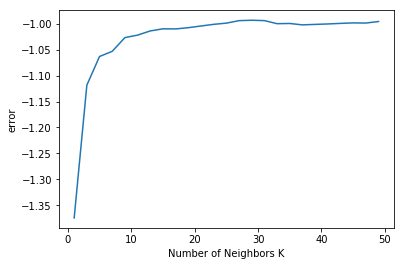

In [35]:
plt.plot(list_neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('error')
plt.show()


In [50]:
print cv_scores.index(max(cv_scores))

14


In [51]:
#let's find the best PCA
PCAList = list(range(2,52))

# empty list that will hold cv scores
cv_scores_pca = []
knn_cv = neighbors.KNeighborsRegressor(n_neighbors=14)
# perform 10-fold cross validation
for k in PCAList:
    ACP_cv = decomposition.PCA(n_components = k)
    ACP_cv.fit(X_reg)
    X_reg_cv = ACP_cv.transform(X_reg)
    scores = model_selection.cross_val_score(knn, X_reg_cv, y_reg, cv=10, scoring='neg_mean_squared_log_error')
    cv_scores_pca.append(scores.mean())

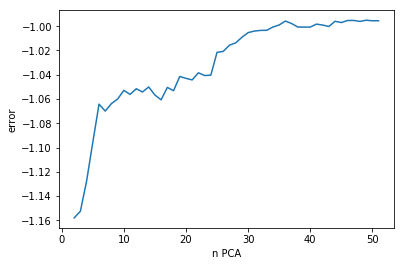

In [53]:
plt.plot(PCAList, cv_scores_pca)
plt.xlabel('n PCA')
plt.ylabel('error')
plt.show()

In [54]:
print cv_scores_pca.index(max(cv_scores_pca))

47


In [63]:
#let's fit that shiiiiiit
knn_14 = neighbors.KNeighborsRegressor(14)
PCA_47 = decomposition.PCA(47)
PCA_47.fit(X_reg)
X_reg_47 = PCA_47.transform(X_reg)
X_test_47 = PCA_47.transform(X_test)
knn_14.fit(X_reg_47, y_reg)
y_test_14_47 = knn_14.predict(X_test_47)
y_test_14_47 = fit_for_kaggle(y_test_14_47)
Export_for_Kaggle(y_test_14_47, "solution_knn_14_47.csv")